- 자연어 문제를 위해 많이 사용하는 방법은 순환 신경망이다.
- 문장에서 다음 글자를 예측하도록 훈련하는 문자 단위 RNN부터 시작한다.
- 상태가 없는 RNN을 사용하고 상태가 있는 RNN을 구축한다.
> - 상태가 없는 RNN은 각 반복에서 무작위하게 택한 텍스트에서 일부분으로 학습하고, 나머지 텍스트에서 어떤 정보도 사용 안한다.
>- 상태가 있는 RNN은 훈련 반복 사이에 은닉 상태를 유지하고 중지된 곳에서 이어서 상태를 반영한다.


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


     |████████████████████████████████| 706kB 8.1MB/s 


# 16.1 Char-RNN을 사용해 셰익스시어 문체 생성하기

- 셰익스피어 작품 다운로드

In [ ]:
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1122304/1115394 [==============================] - 0s 0us/step


In [ ]:
print(shakespeare_text[:148])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?



- 모든 글자를 정수로 인코딩
- 케라스의 tokenizer 클래스를 사용한다.
- 텍스트에서 사용되는 모든 글자를 찾아 각기 다른 글자 ID에 매핑한다.
- ID는 1부터 시작해 고유한 글자 개수까지 만들어진다.

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

- char_level=True로 지정하여 단어 수준 인코딩 대신 글자 수준 인코딩을 만든다.
- 문장을 글자 ID로 인코딩하거나 반대로 디코딩 할수있다. 
- 텍스트에 있는 고유 글자 개수와 전체 글자 개수를 알수 있다.

- 파이썬에서 가장 기본적인 데이터 구조는 시퀀스입니다. 시퀀스란 데이터를 순서대로 하나씩 나열하여 나타낸 데이터 구조입니다. 
- 시퀀스의 각 요소에는 특정 위치(~번째)의 데이터를 가리키는 인덱스가 지정됩니다. 첫 번째 인덱스는 0이고, 두 번째 인덱스는 1입니다. 
- 파이썬에는 여섯 가지 시퀀스 유형이 있지만 가장 일반적인 것은 list과 tuple입니다. 

In [ ]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [ ]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [ ]:
max_id = len(tokenizer.word_index) # 고유 글자 개수
dataset_size = tokenizer.document_count # 전체 글자 개수

In [ ]:
# 1에서 39 대신 0~38 ID를 위해 -1을 해줌
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

## 16.1.2 순차 데이터셋을 나누는 방법

- RNN은 암묵적으로 학습하는 패턴이 미래에도 등장한다고 가정한다.
- 시계열 데이터가 변하지 않는다 고 가정한다.
- 시계열 데이터가 충분히 안정적인지 확인하려면 시간에 따라 검증 세트에 대한 모델의 오차를 그려볼수 있다.
- 모델이 검증 세트 마지맘ㄱ 보다 첫 부분에서 성능이 좋다면 시계열은 충분히 안정되지 않은것이다. 이럴때는 더 짧은 간격으로 모델을 훈련 시켜야한다.

In [ ]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size]) # 한번에 한글자씩반환하는 dataset객체를 만든다.

## 16.1.3 순차 데이터를 윈도 여러개로 자르기

- 훈련 세트는 백만개 이상의 글자로 이루어진 시퀀스 이기 때문에 직접 신경망에 훈련 시키기 어렵다.
- window() 메서드를 사용하여 긴 시퀀스를 작은 많은 텍스트 윈도로 변환한다.
- 데이터셋의 각 샘플은 전체 텍스트에서 매우 짧은 부분 문자열이다.
- RNN은 부분 문자열 길이만큼 역전파를 한다. TBPTT라 부른다.

In [ ]:
n_steps = 100
window_length = n_steps + 1 # target = 1글자 앞의 input
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

- window()메서드는 윈도를 중복하지 않는다.
- shift=1로 지정하면 가장 큰 훈련세트를 만들수 있다.
> 첫 번째 윈도는 0~100번째 글자를 포함하고 두번째 윈도는 1 ~ 101번째 글자를 포함하는 식이다.
- 모든 윈도가 동일하게 101개의 글자를 포함하도록 drop_remainder=True 로 지정한다.
> 지정 안하면 1개씩 줄어들어서 마지막 윈도는 글자 1개를 포함한다.

- window()메서드는 각각 하나의 데이터셋으로 표현되는 윈도우를 포함하는 데이터셋을 만든다. 리스트의 리스트와 비슷한 중첩 데이터셋이다. 
> 데이터셋 메서드를 호출하여 각 윈도를 변환할때 유용하다.
- flat_map()을 사용하여 중첩데이터셋을 플랫 데이터셋으로 변환해야 사용이 가능하다.

In [ ]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

- 윈도마다 batch(window_length)를 호출한다. 이 길이는 윈도 길이와 같기 때문에 텐서 하나를 담은 데이터셋을 얻는다.

In [ ]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size) # 윈도 배치
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))# 입력과 타깃을 분리

- 윈도 데이터셋 설명

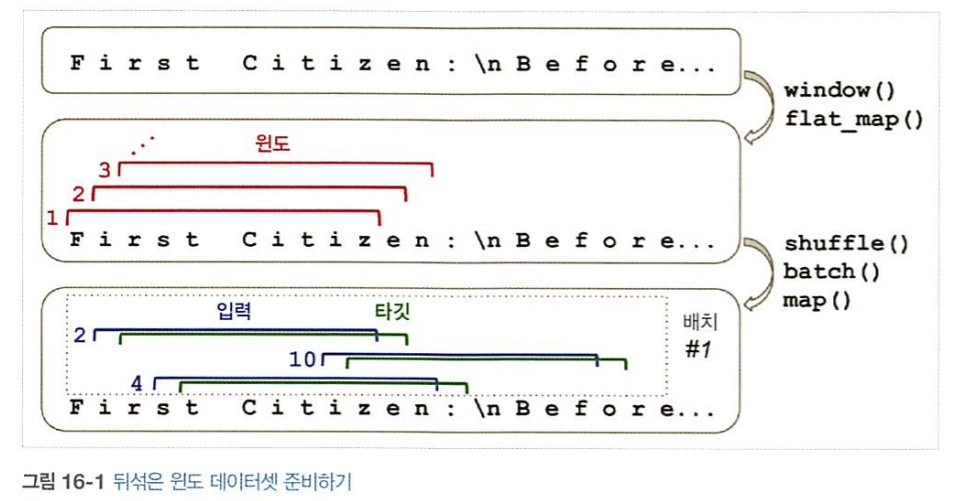

In [ ]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)) #원핫벡터로 인코딩

In [ ]:
dataset = dataset.prefetch(1)

## 16.1.4 Char-RNN 모델 만들고 훈련하기

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],# 유닛128개를 가진 GRU층 2개
                     dropout=0.2, recurrent_dropout=0.2), # 입력 과 은닉에 20% 드롭아웃 사용
    keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id, # 텍스트에 있는 고유한 글자수 39개이므로 39개의 유닛을 가져옴
                                                    activation="softmax"))# 각 글자에 대한 확률출력 합은 1이기 때문에 softmax사용
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10)

Epoch 1/10
31370/31370 [==============================] - 20396s 650ms/step - loss: 1.5929
Epoch 2/10
 8733/31370 [=======>......................] - ETA: 4:00:33 - loss: 1.3791

KeyboardInterrupt: ignored

## 16.1.5 Char-RNN모델 사용하기

전처리를 위해 함수를 생성

In [ ]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

In [ ]:
X_new = preprocess(["How are yo"])
Y_pred = model.predict_classes(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1] # 1st sentence, last char

## 16.1.6 가짜 셰익스피어 텍스트 생성하기

1. 초기 텍스트를 주입하고 모델이 가장 가능성 있는 다음 글자를 예측
2. 글자를 텍스트 끝에 추가하고 늘어난 텍스트를 모델에 전달하여 다음 글자를 예측
3. categorical()함수를 사용해 모델이 추정한 확률을 기반으로 다음 글자를 무작위로 선택가능
> categorical()함수는 클래스의 로그 확률을 저달하면 랜덤하게 클래스 인덱스를 샘플링함
4. 다양성을 제어하려면 온도라고 불리는 숫자로 로짓을 바꾼다
> - 0에 가까울수록 높은 확률을 가진 글자를 선택한다.
> - 온도가 매우 높으면 모든 글자가 동일한 확률을 가진다.
5. next_char()함수는 다음 글자를 선택하고 입력 테스트에 추가

In [ ]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new)[0, -1:, :]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

- next_char함수를 반복 호출하여 다음 글자를 얻고 텍스트에 추가하는 작은 함수를 만듬

In [ ]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [ ]:
print(complete_text("t", temperature=0.2))

In [ ]:
print(complete_text("t", temperature=1))

In [ ]:
print(complete_text("t", temperature=2))

- 온도 1에 가장 잘 작동한다.
- 좋은 텍스트 생성을 위해 GRU층과  층의 뉴런수를 늘리고 더 오래 훈련 하거나 규제를 추가한다.

# 16.1.7 상태가 있는 RNN

- 훈련 반복마다 모델의 은닉 상태를 0으로 초기화한다. - 타임스텝마다 이 상태를 업데이트하고 마지막 타임스텝 후에는 더 필요가 없기 때문에 버린다. 
- RNN이 한 훈련 배치를 처리한 후에 마지막 상태를 다음 훈련 배치의 초기 상태로 사용하면 역전파는 짧은 시퀀스에서 일어나지만 모델이 장기간 패턴을 학습할 수 있다. 
- 이를 상태가 있는 RNN이라고 한다.

- 상태가 있는 RNN은 배치에 있는 각 입력 시퀀스가 이전 배치의 시퀀스가 끝난 지점에서 시작해야한다.
- 첫 번째로 할 인은 순차적이고 겹치지 않는 입력 시퀀스를 만드는 것이다.
- window() 메서드에서 shift=n_steps를 사용한다. shuffle()은 사용하면 안된다.
- 배치 구성이 어렵다.
> 해결책은 하나의 윈도를 같는 배치를 만드는것

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.repeat().batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:])) # 연속적인 배치를 만든다.
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))
dataset = dataset.prefetch(1)

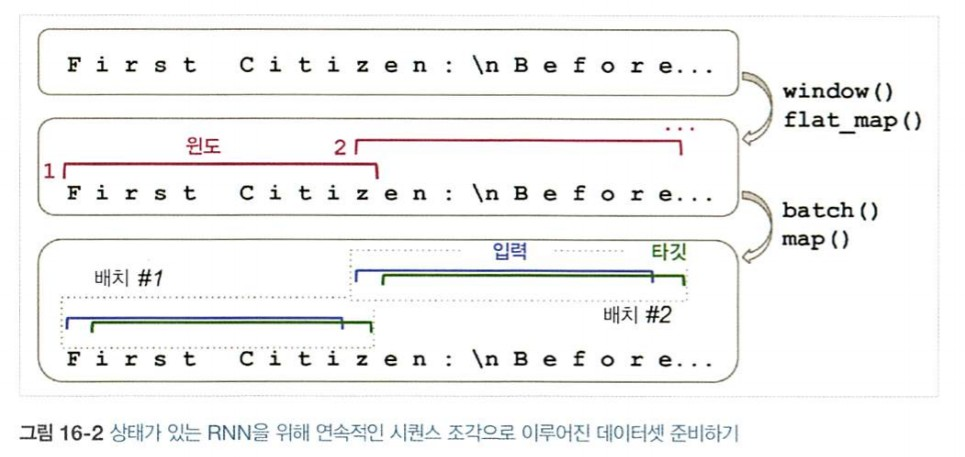

- 셰익스피어의 텍스트를 길이가 동일한 32개의 텍스트로 나누고 각 텍스트에 대해 연속적인 입력 시퀀스를 가진 데이터셋을 만들수잇따.
- tf.train.Dataset.zip().map()를 통해연속적인 배치를 만든다.
- 여기에서 한 배치에서 n번째 입력 시퀀스의 시작은 정확히 이전 배치의 n번째 입력 시퀀스가 끝나는 지점이다.

In [ ]:
model = keras.models.Sequential([
    keras.layers.GRU(128, return_sequences=True, stateful=True, # 각 순환층에 stateful=True 로 지정해야한다.
                     dropout=0.2, #recurrent_dropout=0.2,
                     batch_input_shape=[batch_size, None, max_id]), # batch 크기를 알기위해 input_shape를 사용
    keras.layers.GRU(128, return_sequences=True, stateful=True, # 각 순환층에 stateful=True 로 지정해야한다.
                     dropout=0.2), #recurrent_dropout=0.2),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,
                                                    activation="softmax"))
])

In [ ]:
class ResetStatesCallback(keras.callbacks.Callback): # 에포크 끝마다 텍스트를 다시 시작하기전에 상태를 재설정
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
steps_per_epoch = train_size // batch_size // n_steps
history = model.fit(dataset, steps_per_epoch=steps_per_epoch, epochs=50,
                    callbacks=[ResetStatesCallback()])

# 16.2 감정분석

In [ ]:
(X_train, y_test), (X_valid, y_test) = keras.datasets.imdb.load_data()

- 리뷰는 이미 전처리 되있다.
- 각 리뷰는 넘파이 정수 배열로 표현된다.
- 각 정수는 하나의 단어를 나타낸다.
- 구두점을 모두 제거하고 단어는 소문자로 변환한 다음 공백으로 나누어 빈도에 따라 인덱스를 붙인다.

In [ ]:
word_index = keras.datasets.imdb.get_word_index()
id_to_word = {id_ + 3: word for word, id_ in word_index.items()}
for id_, token in enumerate(("<pad>", "<sos>", "<unk>")):# 0은 패팅토큰 1은 SOS토큰 2는 알수없는 단어를 의미한다.
    id_to_word[id_] = token
" ".join([id_to_word[id_] for id_ in X_train[0][:10]])

- Tokenizer 클래스를 사용한다.
- char_level=False로 사용
- 공백을 사용해 단어를 구분한다.
- 언어마다 다르다.

- 전처리를 모델 자체에 포함시킬 수 있다.

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

전처리 함수

In [ ]:
def preprocess(X_batch, y_batch): # preprocess함수는 리뷰를 공백으로 나눈다. 이때 래그드 텐서가 반환된다.
    X_batch = tf.strings.substr(X_batch, 0, 300) # 훈련 속도를 높이기 위해 각 리뷰에서 처음 300 글자만 남긴다. 리뷰의 긍/부정을 판단할수있다.
    X_batch = tf.strings.regex_replace(X_batch, rb"<br\s*/?>", b" ") # <br /> 태그를 공백으로 바꾼다, .
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ") # 문자와 작은 따옴표가 아닌 다른 모든 무자를 공백으로 바꾼다
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch # 모든 리뷰를 패딩한다

In [ ]:
from collections import Counter # counter로 단어의 등장 횟수를 샌다.

vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

- 단어 3개 확인

In [ ]:
vocabulary.most_common()[:3]

In [ ]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]] # 가장 많이 등장하는 단어 10,000만 남기고 삭제

In [ ]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64) # 각단어를 ID로 바꾸는 전처리단계
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids) 
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets) # 1000개의 oov버킷을 사용하는 룩업테이블을 만든다.

In [ ]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

In [ ]:
def encode_words(X_batch, y_batch): 
    return table.lookup(X_batch), y_batch

train_set = datasets["train"].repeat().batch(32).map(preprocess) # 리뷰를 배치로 묶고 함수를 사용해 단어의 짧은 시퀀스로 바꾼다.
train_set = train_set.map(encode_words).prefetch(1) # encode_words()로 단어를 인코딩한다. 다음 배치를 프리페치한다.

In [ ]:
embed_size = 128 # 튜닝 가능하다.
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size, # 단어 ID를 임베딩으로 변환하는 Embedding층이다.
                           input_shape=[None]), # 임베딩 행렬은 단어 ID당 하나의 행과 임베딩 차원당 하나의 열을 가진다.
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

- 모델입력은 [배치크기, 타임스텝수]크기를 가진 2D텐서다
- Embedding 층의 출력은 [배치크기, 타임스텝수, 임베딩크기] 크기를 가진 3D 텐서가 된다.

## 16.2.1 마스킹

- 원래 데이터 그대로 모델이 패딩 토큰을 무시해야 한다.
- 패딩토큰을 무시하도록 mask_zero=True를 사용한다.
- 모든층에서 ID=0인 토큰을 전부 무시한다.

- 층마다 마스크 텐서를 다르게 다룰 수 있지만 일반적으로 마스킹된 타임 스텝을 무시한다. (False로 마스킹된 타임스텝)

- 마스크를 받은 모든 층은 마스크를 지원해야한다.
- supports_masking=True
- 사용자 정의층을 구현하려면 call()메서드에서 mask매개변수를 추가한다.
- keras.layers.Masking층을 사용할수있다.
- Sequential모델과 잘 어울린다.

In [ ]:
K = keras.backend
embed_size = 128
inputs = keras.layers.Input(shape=[None])
# 모델에 의해 이어지는 모든 층에 타임 스텝 차원이 유지돠는 한 자동으로 전파
mask = keras.layers.Lambda(lambda inputs: K.not_equal(inputs, 0))(inputs) # 입력과 크기가 같은 불리언 텐서 ID=0이면 false 나머지는 True
z = keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size)(inputs)
z = keras.layers.GRU(128, return_sequences=True)(z, mask=mask)
z = keras.layers.GRU(128)(z, mask=mask) # 사퀀스를 반환하지 않는다.
outputs = keras.layers.Dense(1, activation="sigmoid")(z) # 마스크 텐서가 전달되지 않는다.
model = keras.models.Model(inputs=[inputs], outputs=[outputs])
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(train_set, steps_per_epoch=train_size // 32, epochs=5)

## 16.2.2 사전훈련된 임베딩 재사용하기

사전 훈련된 모델 컴포넌트를 모델에 추가하기 쉽게 만들어준다. 이를 모듈이라 부른다.

In [ ]:
import tensorflow_hub as hub

model = keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", # 이 층은 훈련이 되지않는다.
                   dtype=tf.string, input_shape=[], output_shape=[50]), # trainable = True로 미세조정이 가능
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
              metrics=["accuracy"])

- 문자열을 입력으로 받아 하나의 벡터로 인코딩한다.
- 문자열을 파싱(공백으로 단어나눔)해서 대규모 코퍼스에서 사전훈련된 이베딩 행렬을 사용해 각 단어를 임배딩한다.

In [ ]:
import tensorflow_datasets as tfds

datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples
batch_size = 32
train_set = datasets["train"].repeat().batch(batch_size).prefetch(1)
history = model.fit(train_set, steps_per_epoch=train_size // batch_size, epochs=5)

Epoch 1/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5861 - accuracy: 0.6919
Epoch 2/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5181 - accuracy: 0.7445
Epoch 3/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5122 - accuracy: 0.7491
Epoch 4/5
781/781 [==============================] - 4s 6ms/step - loss: 0.5084 - accuracy: 0.7492
Epoch 5/5
781/781 [==============================] - 5s 6ms/step - loss: 0.5054 - accuracy: 0.7520


# 16.3 신경망 기계 번역을 위한 인코더-디코더 네트워크

영어 문장을 인코더로 주입하면 디코더는 프랑스어 번역을 출력한다.

- 디코더는 이전 스텝에서 출력된 단어를 입력으로 사용한다.
- 맨 처음 단어는 SOS토큰으로 시작한다.
- 디코더는 문장 끝에 EOS토큰이 있을것으로 기대한다.

- 영어 문장은 인코더 주입전에 거꾸로 뒤집힌다.
- 각 단어는 초기에 1차원으로 표현되어있다.


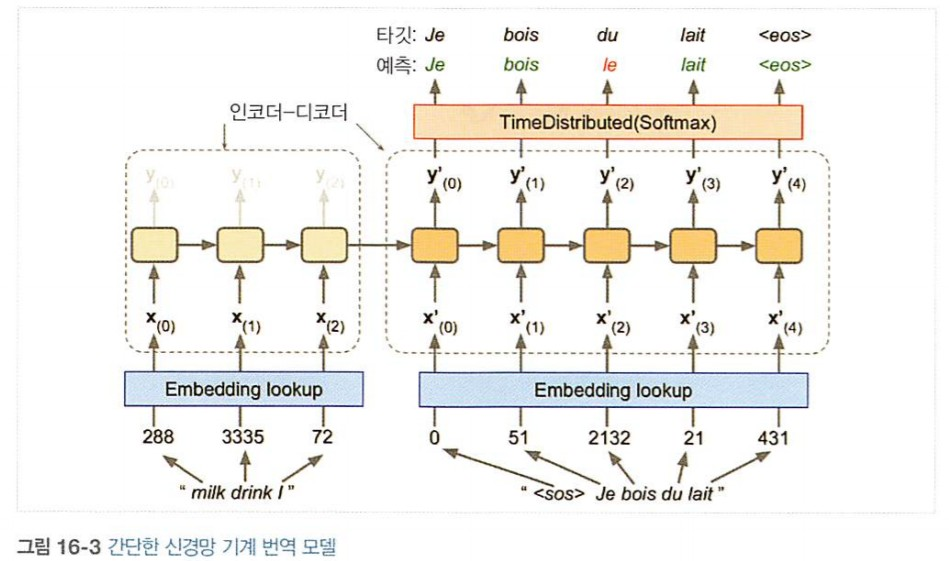

1.  각 단계마다 디코더는 출력 어휘 사전에 있는 단어에 대한 점수를 출력한다.
2. 소프트맥스와 손실함수를 사용해 훈련한다.

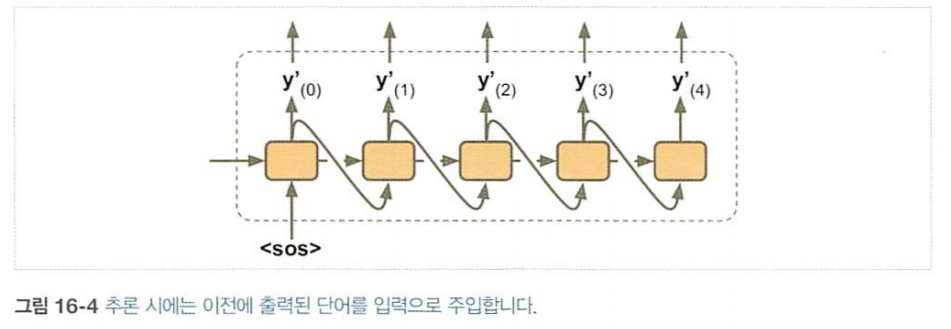

In [7]:
vocab_size = 100
embed_size = 10

In [8]:
import tensorflow_addons as tfa

encoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
decoder_inputs = keras.layers.Input(shape=[None], dtype=np.int32)
sequence_lengths = keras.layers.Input(shape=[], dtype=np.int32)

embeddings = keras.layers.Embedding(vocab_size, embed_size)
encoder_embeddings = embeddings(encoder_inputs)
decoder_embeddings = embeddings(decoder_inputs)

encoder = keras.layers.LSTM(512, return_state=True) # 최종 은닉 상태를 디코더로 보내기 위해 return_state=True를 사용했다.
encoder_outputs, state_h, state_c = encoder(encoder_embeddings)
encoder_state = [state_h, state_c]

# 추론시에는 실제로 출력되는 토큰의 임베딩이 된다.
# 훈련 시에는 이전 타깃 토큰의 임베딩이 되아야 한다.
sampler = tfa.seq2seq.sampler.TrainingSampler() 

decoder_cell = keras.layers.LSTMCell(512)
output_layer = keras.layers.Dense(vocab_size)
decoder = tfa.seq2seq.basic_decoder.BasicDecoder(decoder_cell, sampler,
                                                 output_layer=output_layer)
final_outputs, final_state, final_sequence_lengths = decoder(
    decoder_embeddings, initial_state=encoder_state,
    sequence_length=sequence_lengths)#, training=None)
Y_proba = tf.nn.softmax(final_outputs.rnn_output)

model = keras.models.Model(
    inputs=[encoder_inputs, decoder_inputs, sequence_lengths],
    outputs=[Y_proba])

## 16.3.1 양방향 RNN

- 각 타임 스텝에서 일반적인 순환 층은 과거와 현재의 입력만 보고 출력을 생성한다. 즉 인과적이라 미래를 볼수 없다.
- 이런 RNN은 시계열에는 좋지만 여러종류의 NLP 작업에는 맞지 않는다.
- 동일한 입력에 대해 두 개의 순환층을 실행한다.
> 하나는 왼쪽에서 다른하나는 오른쪽에서 시작한다.
- 일반적으로 타임 스탭마다 이 두 출력을 연결한다. 이를 양방향 순환 층 이라 한다.

In [3]:
keras.layers.Bidirectional(keras.layers.GRU(10,return_sequences=True)) 

- keras.layers.Bidirectional으로 순환 층을 감싼다.
- Bidirectional 층은 GRU층을 복사한다.
- 두 층을 실행하여 그 출력을 연결한다.
- GRU층이 10개의 유닛을 가지면 Bidirectional 층은 타임 스텝마다 20개의 값을 출력한다.

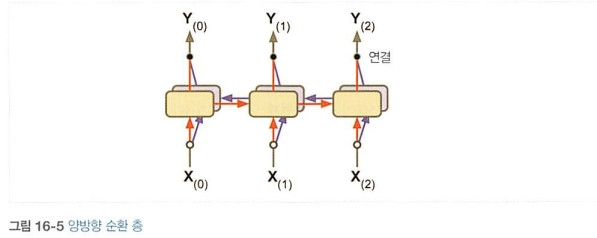

## 16.3.2 빔 검색

모델은 실수가 있더라도 뒤로 돌아가 고칠 수 없어서 가능한 최선을 다해 문장을 완성해야 한다.


- k개의 가능성 있는 문장의 리스트를 유지하고 디코더 단계마다 이 문장의 단어를 하났기 생성하여 가능성 있는 k개의 문장을 만든다.
- k를 빔 너비라고 한다.

In [10]:
beam_width = 10
decoder = tfa.seq2seq.beam_search_decoder.BeamSearchDecoder(
    cell=decoder_cell, beam_width=beam_width, output_layer=output_layer)
decoder_initial_state = tfa.seq2seq.beam_search_decoder.tile_batch(
    encoder_state,multiplier=beam_width)
output, _, _ = decoder(
    embedding_decoder, start_tokens_start_tokens, end_token=end_token,
    initial_state=decoder_initial_state)

NameError: ignored